In [1]:
%matplotlib inline
import numpy as np
from astropy.io import fits
from astropy import wcs
from astropy.coordinates import SkyCoord, EarthLocation, AltAz, ICRS, Longitude, Latitude
import astropy.units as u
from astropy.time import Time
from astropy.table import Table, vstack

import matplotlib.pylab as plt
from read_ybc import readYBC

from astropy.coordinates import SkyCoord
from astropy import units as u

import lsst.all_sky_phot.wcs as asp
from scipy.optimize import minimize

from astropy.coordinates import match_coordinates_sky

In [2]:
def radec2altaz(ra, dec, mjd, location):
    """
    I need a stupid converter
    """
    time = Time(mjd, format='mjd')
    coords = SkyCoord(ra=ra*u.degree, dec=dec*u.degree)
    ack = coords.transform_to(AltAz(obstime=time, location=location))
    return ack.alt.value, ack.az.value

In [3]:
temp = np.load('full_night.npz')
phot_tables = temp['phot_tables'][()]
temp.close()

hdulist = fits.open('wcs_asp_only.fits')
w = wcs.WCS(hdulist[0].header)
hdulist.close()

lsst_location = EarthLocation(lat=-30.2444*u.degree, lon=-70.7494*u.degree, height=2650.0*u.meter)


def coord_trans(ptable, w):
    """
    Take a photometry table and add ra and dec cols
    """
    time = Time(ptable['mjd'].max(), format='mjd')
    az, alt = w.all_pix2world(ptable['xcenter'], ptable['ycenter'], 0)
    coords = AltAz(az=az*u.degree, alt=alt*u.degree, location=lsst_location, obstime=time)
    sky_coords = coords.transform_to(ICRS)
    ptable['alt_rough'] = coords.alt
    ptable['az_rough'] = coords.az
    ptable['ra_rough'] = sky_coords.ra
    ptable['dec_rough'] = sky_coords.dec
    return ptable


ra_r = []
dec_r = []
mjd = []

for ptable in phot_tables:
    ptable = coord_trans(ptable, w)
    ra_r.extend(ptable['ra_rough'].value.tolist())
    dec_r.extend(ptable['dec_rough'].value.tolist())
    mjd.extend(ptable['mjd'].tolist())

names = ['ra', 'dec', 'mjd']
types = [float]*3
data = np.array([ra_r, dec_r, mjd])

/Users/yoachim/lsst/DarwinX86/miniconda2/3.19.0.lsst4/lib/python2.7/site-packages/astropy/coordinates/angles.py:672: RuntimeWarning: invalid value encountered in less
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/Users/yoachim/lsst/DarwinX86/miniconda2/3.19.0.lsst4/lib/python2.7/site-packages/astropy/coordinates/angles.py:672: RuntimeWarning: invalid value encountered in greater_equal
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/Users/yoachim/lsst/DarwinX86/miniconda2/3.19.0.lsst4/lib/python2.7/site-packages/astropy/coordinates/angles.py:563: RuntimeWarning: invalid value encountered in less
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/Users/yoachim/lsst/DarwinX86/miniconda2/3.19.0.lsst4/lib/python2.7/site-packages/astropy/coordinates/angles.py:563: RuntimeWarning: invalid value encountered in greater
  if np.any(angles.value < lower) or np.any(angles.value > upper):
If you need enough precisi

/Users/yoachim/lsst/DarwinX86/miniconda2/3.19.0.lsst4/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in log10
/Users/yoachim/lsst/DarwinX86/miniconda2/3.19.0.lsst4/lib/python2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in log10


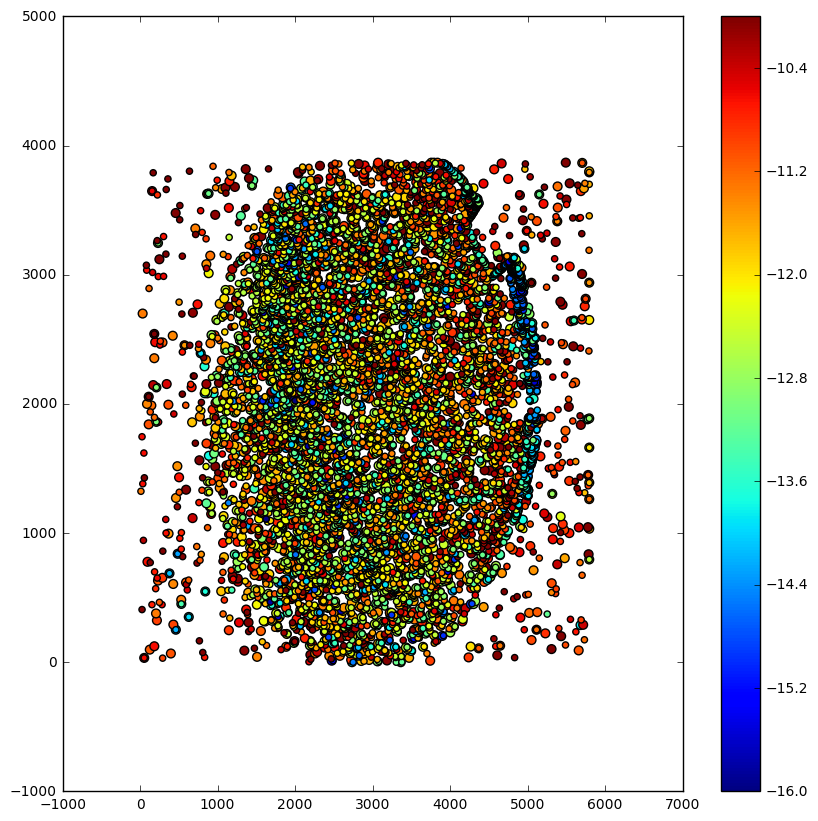

In [4]:
plt.figure(figsize=(10,10))
i=40
plt.scatter(phot_tables[i]['xcenter'], phot_tables[i]['ycenter'], 
            c=-2.5*np.log10(phot_tables[i]['residual_aperture_sum']),
            vmin=-16, vmax=-10, s=40)
#plt.xlim([2000,3000])
#plt.ylim([1000,3000])
plt.colorbar()
i=42
plt.scatter(phot_tables[i]['xcenter'], phot_tables[i]['ycenter'], 
            c=-2.5*np.log10(phot_tables[i]['residual_aperture_sum']),
            vmin=-16, vmax=-10)

/Users/yoachim/lsst/DarwinX86/miniconda2/3.19.0.lsst4/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in log10
/Users/yoachim/lsst/DarwinX86/miniconda2/3.19.0.lsst4/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in less
/Users/yoachim/lsst/DarwinX86/miniconda2/3.19.0.lsst4/lib/python2.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in log10
/Users/yoachim/lsst/DarwinX86/miniconda2/3.19.0.lsst4/lib/python2.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in less


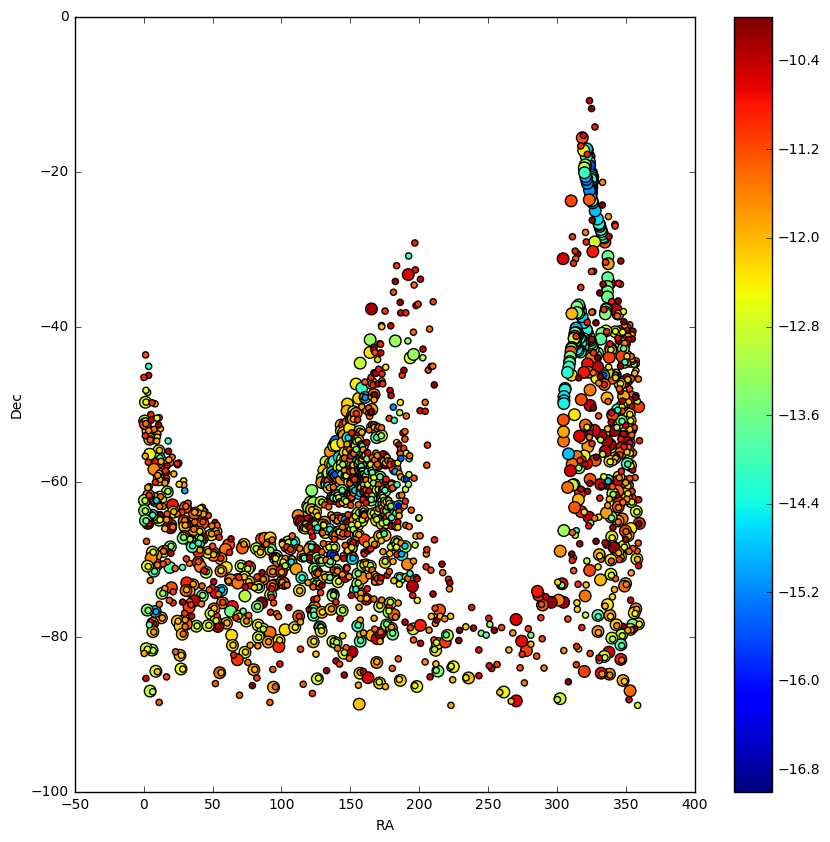

In [5]:
plt.figure(figsize=(10,10))
i=40
mag_max = -10
good = np.where( (phot_tables[i]['xcenter'].value > 1000) & (phot_tables[i]['xcenter'].value < 5000) &
               (phot_tables[i]['ycenter'].value > 3000) & (phot_tables[i]['ycenter'].value < 4000)
               & (-2.5*np.log10(phot_tables[i]['residual_aperture_sum'].data) < mag_max))

plt.scatter(phot_tables[i]['ra_rough'].value[good], phot_tables[i]['dec_rough'].value[good], 
            c=-2.5*np.log10(phot_tables[i]['residual_aperture_sum'].data[good]),
            vmin=-17, vmax=mag_max, s=70)

i=70
good = np.where( (phot_tables[i]['xcenter'].value > 1000) & (phot_tables[i]['xcenter'].value < 5000) &
               (phot_tables[i]['ycenter'].value > 3000) & (phot_tables[i]['ycenter'].value < 4000) &
               (-2.5*np.log10(phot_tables[i]['residual_aperture_sum'].data) < mag_max))

plt.scatter(phot_tables[i]['ra_rough'].value[good], phot_tables[i]['dec_rough'].value[good], 
            c=-2.5*np.log10(phot_tables[i]['residual_aperture_sum'].data[good]),
            vmin=-17, vmax=mag_max)
plt.colorbar()
plt.xlabel('RA')
plt.ylabel('Dec')

/Users/yoachim/lsst/DarwinX86/miniconda2/3.19.0.lsst4/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in log10
/Users/yoachim/lsst/DarwinX86/miniconda2/3.19.0.lsst4/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in less
/Users/yoachim/lsst/DarwinX86/miniconda2/3.19.0.lsst4/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in greater


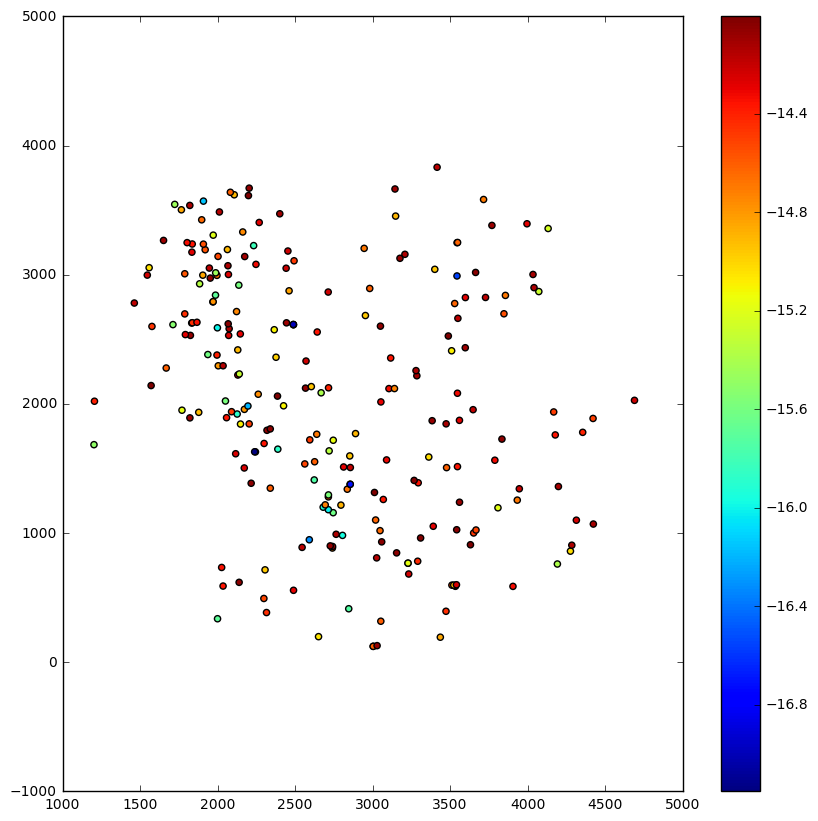

In [6]:
plt.figure(figsize=(10,10))
i=70
mag_max=-14
alt_limit=15
good = np.where((-2.5*np.log10(phot_tables[i]['residual_aperture_sum'].data) < mag_max) &
                (phot_tables[i]['alt_rough'].value > alt_limit))

plt.scatter(phot_tables[i]['xcenter'].value[good], phot_tables[i]['ycenter'].value[good], 
            c=-2.5*np.log10(phot_tables[i]['residual_aperture_sum'].data[good]))
plt.colorbar()

In [7]:
ybc = readYBC()

/Users/yoachim/lsst/DarwinX86/miniconda2/3.19.0.lsst4/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app
/Users/yoachim/lsst/DarwinX86/miniconda2/3.19.0.lsst4/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in less
  from ipykernel import kernelapp as app
/Users/yoachim/lsst/DarwinX86/miniconda2/3.19.0.lsst4/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()


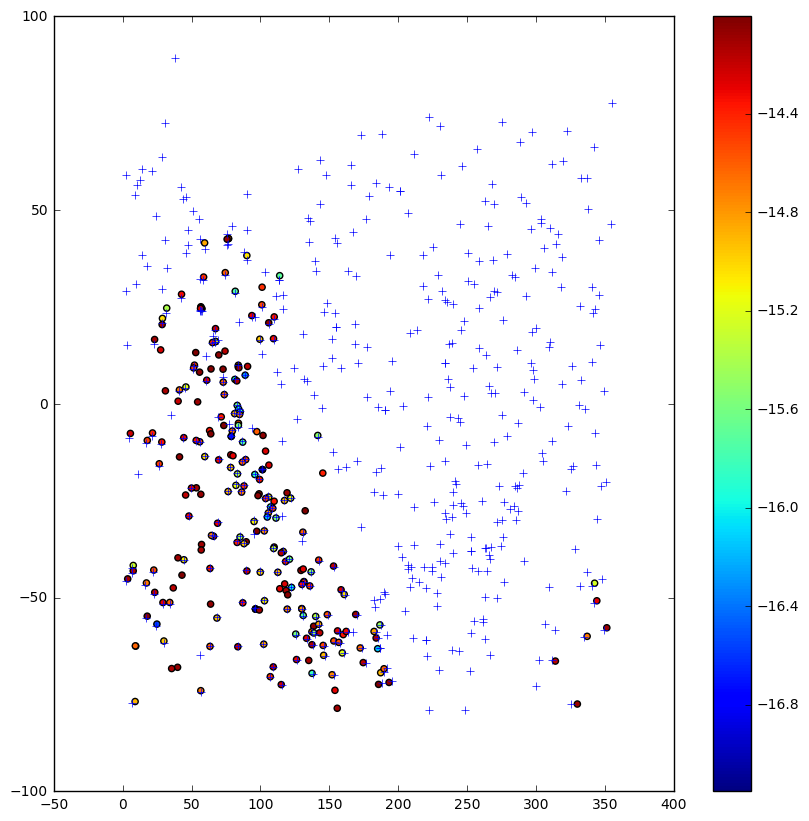

In [8]:
plt.figure(figsize=[10,10])
good = np.where((-2.5*np.log10(phot_tables[i]['residual_aperture_sum'].data) < mag_max) &
                (phot_tables[i]['alt_rough'].value > alt_limit))

plt.scatter(phot_tables[i]['ra_rough'].value[good], phot_tables[i]['dec_rough'].value[good], 
            c=-2.5*np.log10(phot_tables[i]['residual_aperture_sum'].data[good]))
plt.colorbar()

good = np.where(ybc['Vmag'] < 4)
plt.plot(ybc['RA'].values[good], ybc['Dec'].values[good], '+')

In [9]:
# Make an astropy SkyCoord catalog of bright ybc stars
ybc_bright = np.where(ybc['Vmag'].values < 4)
ybc_cat = SkyCoord(ra=ybc['RA'].values[ybc_bright]*u.degree, dec=ybc['Dec'].values[ybc_bright]*u.degree)

/Users/yoachim/lsst/DarwinX86/miniconda2/3.19.0.lsst4/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in less
  from ipykernel import kernelapp as app


In [10]:
good = np.where((-2.5*np.log10(phot_tables[i]['residual_aperture_sum'].data) < mag_max) &
                (phot_tables[i]['alt_rough'].value > alt_limit))

allc = SkyCoord(ra=phot_tables[i]['ra_rough'].value[good]*u.degree,
                dec=phot_tables[i]['dec_rough'].value[good]*u.degree)

/Users/yoachim/lsst/DarwinX86/miniconda2/3.19.0.lsst4/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in log10
  if __name__ == '__main__':
/Users/yoachim/lsst/DarwinX86/miniconda2/3.19.0.lsst4/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':
/Users/yoachim/lsst/DarwinX86/miniconda2/3.19.0.lsst4/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app


In [11]:
idx, d2d, d3d = allc.match_to_catalog_sky(ybc_cat)

In [12]:
len(ybc_cat)

513

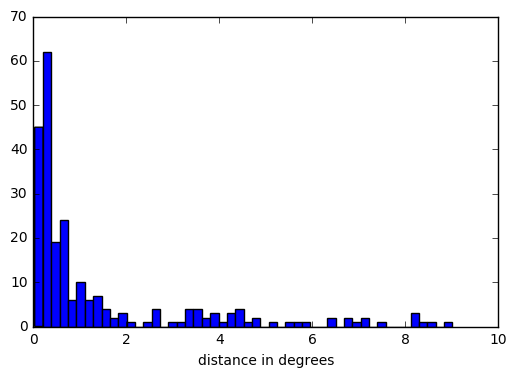

In [13]:
plt.hist(d2d, bins=50)
plt.xlabel('distance in degrees')

In [14]:
# Let's crop down to where the distance is within 1.5 degrees
close = np.where(d2d < 1.5*u.degree)
idx = idx[close]
good = good[0][close]
good_stars = good.copy()

/Users/yoachim/lsst/DarwinX86/miniconda2/3.19.0.lsst4/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in log10
  if __name__ == '__main__':


(array([  2.,   1.,   5.,  38.,  59.,  26.,  23.,   9.,   2.,   5.,   4.,
          0.,   3.,   0.,   0.,   1.,   0.,   0.,   0.,   1.]),
 array([-19.02850641, -18.81212957, -18.59575274, -18.3793759 ,
        -18.16299907, -17.94662223, -17.73024539, -17.51386856,
        -17.29749172, -17.08111489, -16.86473805, -16.64836122,
        -16.43198438, -16.21560755, -15.99923071, -15.78285388,
        -15.56647704, -15.35010021, -15.13372337, -14.91734654, -14.7009697 ]),
 <a list of 20 Patch objects>)

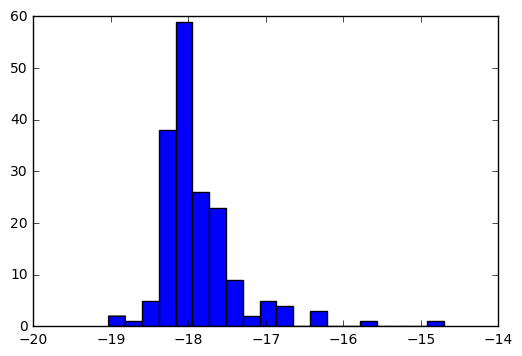

In [15]:
all_sky_mag = -2.5*np.log10(phot_tables[i]['residual_aperture_sum'].data)[good]
plt.hist(all_sky_mag - ybc['Vmag'].values[ybc_bright][idx], bins=20)

In [16]:
zp = np.median(all_sky_mag - ybc['Vmag'].values[ybc_bright][idx])
print zp

-17.9860330084


In [17]:
np.std(all_sky_mag - ybc['Vmag'].values[ybc_bright][idx])

0.51534231677904851

In [18]:
# Now I have a zeropoint. So I can loop through my phot_tables, add columns for ['ra_ybc'], ['dec_ybc], ['ybc_HR']

# Maybe re-run the wcs fit since I have more stars now?

# Maybe make a fake distance for matching purposes. say, mu = m-M = 3. Then d_matching = 10.**(mu/5.+1)

In [19]:
# Oops, need to fit altAz. Not RA, Dec.

alt, az = radec2altaz(ybc['RA'].values[ybc_bright][idx], ybc['Dec'].values[ybc_bright][idx], phot_tables[i]['mjd'].max(), location=lsst_location)

notnan = ~np.isnan(alt)
fun = asp.wcs_azp(phot_tables[i]['xcenter'][good][notnan].value, phot_tables[i]['ycenter'][good][notnan].value,
                  alt[notnan], az[notnan],
                 a_order=0, b_order=0)
# The x0 vector that didn't have any SIP
init_x0 = fun.wcs2x0(w)
fit_result = minimize(fun, init_x0, method='Powell')

In [20]:
print 'Fit result for no SIP, based on %i stars' % ybc['Dec'].values[ybc_bright][idx].size
fit_result.x

Fit result for no SIP, based on 179 stars


array([  2.86988965e+03,   1.97788320e+03,   1.23364526e+00,
         1.03007540e+00,   2.91756184e-02,   2.14347193e-03,
         2.49332866e-03,  -3.51619397e-02,   2.60037594e+00,
        -7.94183520e-01])

In [21]:
print 'previous fit'
fun.wcs2x0(w)

previous fit


array([  2.87267194e+03,   1.98194944e+03,   1.23546388e+00,
         1.02932540e+00,   2.91681385e-02,   2.20383040e-03,
         2.77018818e-03,  -3.50779379e-02,   2.59333243e+00,
        -1.99433904e+00])

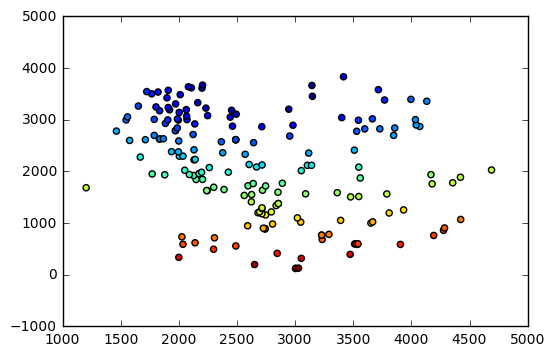

In [22]:
plt.scatter(phot_tables[i]['xcenter'][good][notnan].value, phot_tables[i]['ycenter'][good][notnan].value, c=phot_tables[i]['dec_rough'][good][notnan].value)

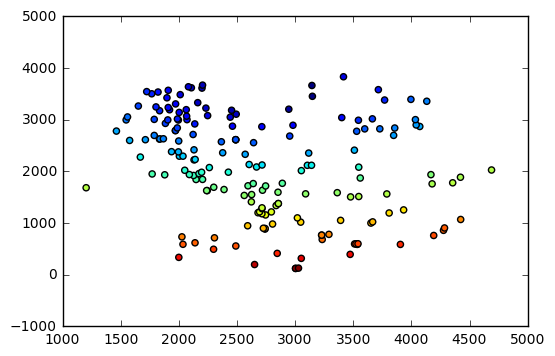

In [23]:
plt.scatter(phot_tables[i]['xcenter'][good][notnan].value, phot_tables[i]['ycenter'][good][notnan].value, c=ybc['Dec'].values[ybc_bright][idx][notnan])

In [24]:
# let's see if we did indeed improve the fit
newdsq = fun(fit_result.x)
olddsq =  fun(fun.wcs2x0(w))
print 'new refined fit', fun(fit_result.x)
print 'previous fit', fun(fun.wcs2x0(w))

if olddsq > newdsq:
    print 'Yes, we improved the fit'

new refined fit 23508.8449566
previous fit 43205.5792122
Yes, we improved the fit


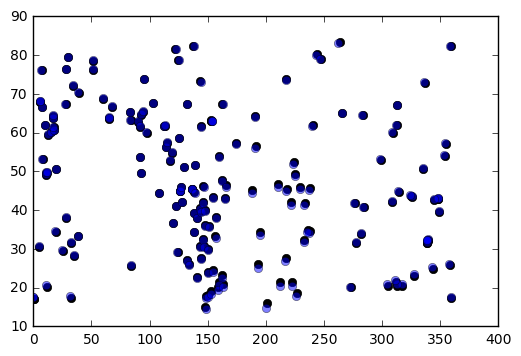

In [25]:
# make sure we didn't do it by making a bunch of NaNs or something
old_alt, old_az = w.all_pix2world(fun.x, fun.y, 0)
new_w = fun.return_wcs(fit_result.x)
new_alt, new_az = new_w.all_pix2world(fun.x, fun.y, 0)
plt.plot(old_alt, old_az, 'ko')
plt.plot(new_alt, new_az, 'bo', alpha=.5)

In [26]:
wcs_refined = fun.return_wcs(fit_result.x)
refined_table = coord_trans(phot_tables[i], wcs_refined)

/Users/yoachim/lsst/DarwinX86/miniconda2/3.19.0.lsst4/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app
/Users/yoachim/lsst/DarwinX86/miniconda2/3.19.0.lsst4/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in less
  from ipykernel import kernelapp as app
/Users/yoachim/lsst/DarwinX86/miniconda2/3.19.0.lsst4/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()


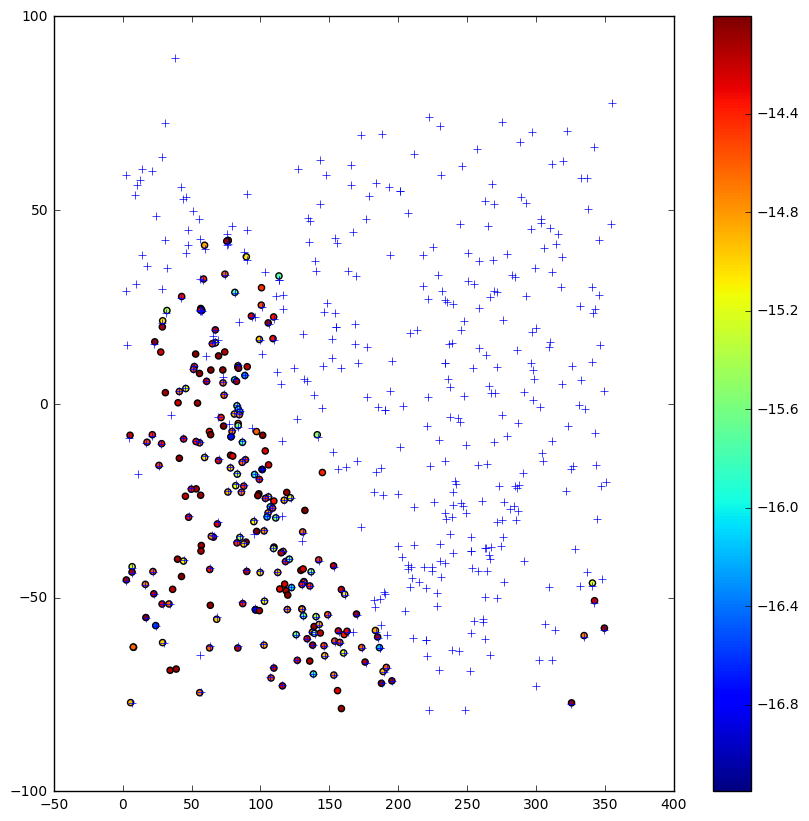

In [27]:
plt.figure(figsize=[10,10])
good = np.where((-2.5*np.log10(refined_table['residual_aperture_sum'].data) < mag_max) &
                (refined_table['alt_rough'].value > alt_limit))

plt.scatter(refined_table['ra_rough'].value[good], refined_table['dec_rough'].value[good], 
            c=-2.5*np.log10(refined_table['residual_aperture_sum'].data[good]))
plt.colorbar()

good = np.where(ybc['Vmag'] < 4)
plt.plot(ybc['RA'].values[good], ybc['Dec'].values[good], '+')

In [28]:
fun.wcs2x0(w)

array([  2.87267194e+03,   1.98194944e+03,   1.23546388e+00,
         1.02932540e+00,   2.91681385e-02,   2.20383040e-03,
         2.77018818e-03,  -3.50779379e-02,   2.59333243e+00,
        -1.99433904e+00])

In [29]:
# check that doing the conversion with SIP set to zero works:
fun_sip = asp.wcs_azp(phot_tables[i]['xcenter'][good_stars][notnan].value, phot_tables[i]['ycenter'][good_stars][notnan].value,
                      alt[notnan], az[notnan],
                      a_order=5, b_order=5)

In [30]:
x0 = np.zeros(fun_sip.b_ind.max()+1)
#x0[fun_sip.a_ind[0:2]] = 1e-6
x0[0:fit_result.x.size] = fit_result.x
fun_sip(x0), fun(fit_result.x)

(23508.844956624263, 23508.844956624263)

In [31]:
fit_result_sip = minimize(fun_sip, x0, method='Powell')

/Users/yoachim/lsst/DarwinX86/miniconda2/3.19.0.lsst4/lib/python2.7/site-packages/scipy/optimize/optimize.py:1850: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/Users/yoachim/lsst/DarwinX86/miniconda2/3.19.0.lsst4/lib/python2.7/site-packages/scipy/optimize/optimize.py:1851: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1


In [32]:
fit_result_sip.fun

8357.1447641056166

In [33]:
fit_result_sip.x

array([  2.86913584e+03,   1.98715167e+03,   1.23635042e+00,
         1.02727189e+00,   2.91782496e-02,   2.11622138e-03,
         2.56923395e-03,  -3.51263771e-02,   2.59503662e+00,
        -5.72746713e-01,   6.25228143e-01,   2.52644603e-06,
        -2.11524293e-06,  -5.43049593e-11,   0.00000000e+00,
         0.00000000e+00,  -7.48613754e-04,  -7.97775621e-06,
        -6.83019584e-10,   0.00000000e+00,   0.00000000e+00,
         6.54327470e+01,  -1.65178077e-06,   7.35724629e-10,
         0.00000000e+00,   0.00000000e+00,   6.54327470e+01,
         6.54327470e+01,   1.14458113e-09,   0.00000000e+00,
         0.00000000e+00,   6.54327470e+01,   6.54327470e+01,
         6.54327470e+01,   0.00000000e+00,   0.00000000e+00,
         6.54327470e+01,   6.54327470e+01,   6.54327470e+01,
         6.54327470e+01,   0.00000000e+00,   6.54327470e+01,
         6.54327470e+01,   6.54327470e+01,   6.54327470e+01,
         6.54327470e+01,  -2.08382598e+00,   2.56203015e-04,
         3.52190626e-06,

In [34]:
fit_result.x

array([  2.86988965e+03,   1.97788320e+03,   1.23364526e+00,
         1.03007540e+00,   2.91756184e-02,   2.14347193e-03,
         2.49332866e-03,  -3.51619397e-02,   2.60037594e+00,
        -7.94183520e-01])

In [35]:
fit_result_sip.x

array([  2.86913584e+03,   1.98715167e+03,   1.23635042e+00,
         1.02727189e+00,   2.91782496e-02,   2.11622138e-03,
         2.56923395e-03,  -3.51263771e-02,   2.59503662e+00,
        -5.72746713e-01,   6.25228143e-01,   2.52644603e-06,
        -2.11524293e-06,  -5.43049593e-11,   0.00000000e+00,
         0.00000000e+00,  -7.48613754e-04,  -7.97775621e-06,
        -6.83019584e-10,   0.00000000e+00,   0.00000000e+00,
         6.54327470e+01,  -1.65178077e-06,   7.35724629e-10,
         0.00000000e+00,   0.00000000e+00,   6.54327470e+01,
         6.54327470e+01,   1.14458113e-09,   0.00000000e+00,
         0.00000000e+00,   6.54327470e+01,   6.54327470e+01,
         6.54327470e+01,   0.00000000e+00,   0.00000000e+00,
         6.54327470e+01,   6.54327470e+01,   6.54327470e+01,
         6.54327470e+01,   0.00000000e+00,   6.54327470e+01,
         6.54327470e+01,   6.54327470e+01,   6.54327470e+01,
         6.54327470e+01,  -2.08382598e+00,   2.56203015e-04,
         3.52190626e-06,

In [36]:
wcs_refined = fun_sip.return_wcs(fit_result_sip.x)
refined_table = coord_trans(phot_tables[i], wcs_refined)

/Users/yoachim/lsst/DarwinX86/miniconda2/3.19.0.lsst4/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app
/Users/yoachim/lsst/DarwinX86/miniconda2/3.19.0.lsst4/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in less
  from ipykernel import kernelapp as app
/Users/yoachim/lsst/DarwinX86/miniconda2/3.19.0.lsst4/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()


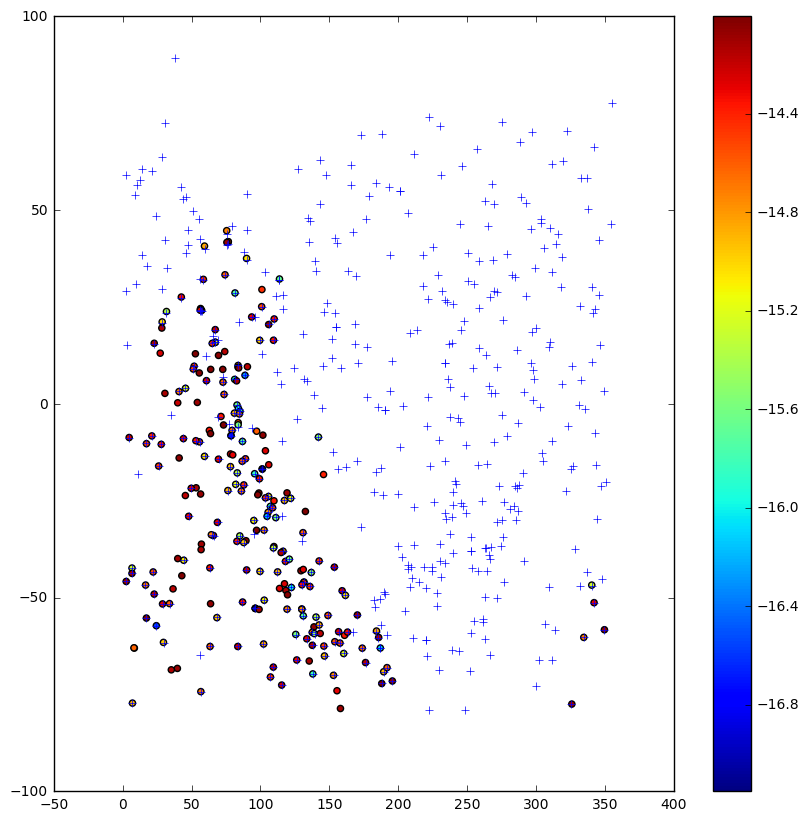

In [37]:
plt.figure(figsize=[10,10])
good = np.where((-2.5*np.log10(refined_table['residual_aperture_sum'].data) < mag_max) &
                (refined_table['alt_rough'].value > alt_limit))

plt.scatter(refined_table['ra_rough'].value[good], refined_table['dec_rough'].value[good], 
            c=-2.5*np.log10(refined_table['residual_aperture_sum'].data[good]))
plt.colorbar()

good = np.where(ybc['Vmag'] < 4)
plt.plot(ybc['RA'].values[good], ybc['Dec'].values[good], '+')

In [38]:
# Let's look at the residuals in pixels!
pix_x, pix_y = wcs_refined.all_world2pix(az[notnan], alt[notnan], 0)
resid_x = pix_x-phot_tables[i]['xcenter'][good_stars][notnan].value
resid_y =  pix_y-phot_tables[i]['ycenter'][good_stars][notnan].value
radial_resid = (resid_x**2 + resid_y*2)**0.5

/Users/yoachim/lsst/DarwinX86/miniconda2/3.19.0.lsst4/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in sqrt


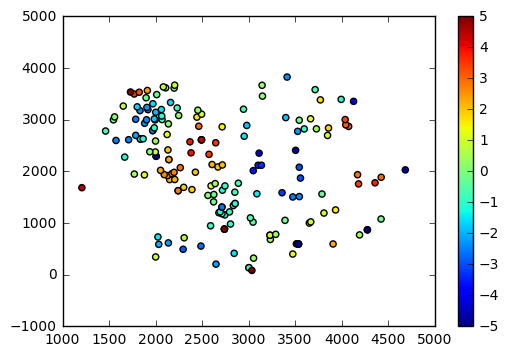

In [39]:
plt.scatter(pix_x, pix_y, c=resid_x, vmax=5, vmin=-5)
cb = plt.colorbar()

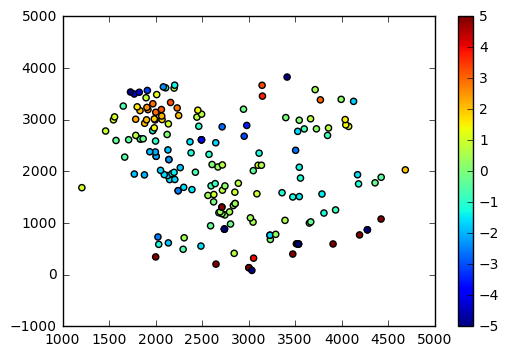

In [40]:
plt.scatter(pix_x, pix_y, c=resid_y, vmax=5, vmin=-5)
cb = plt.colorbar()

In [41]:
# Let's go ahead and run apply this refined WCS to all the photometry tables
for ptable in phot_tables:
    ptable = coord_trans(ptable, wcs_refined)


In [42]:
# Now to loop through the photometry tables, and match to the bright star catalog
phot_tables[40]

id,xcenter,ycenter,aperture_sum_0,aperture_sum_1,residual_aperture_sum,mjd,alt_rough,az_rough,ra_rough,dec_rough
,pix,pix,,,,,deg,deg,deg,deg
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,3362.02982772,0.558556094908,160193.384914,58396.7546705,108053.425387,57415.0323611,8.8286298185,350.189237297,52.2186282387,49.7499457169
2,2733.32986198,0.568254328072,381126.225141,15951.6355576,366883.693393,57415.0323611,11.9522179081,8.31022905099,79.3070220493,47.0361161715
3,3062.95548732,6.90491257689,132546.349572,-14749.3603657,145715.421327,57415.0323611,11.9193979879,358.649767982,65.3671433167,47.7789117207
4,2851.83809244,10.0827452988,-14763.2061351,-75233.7751428,52409.8073853,57415.0323611,12.6285814489,4.8378782968,74.2465089062,46.8510302993
5,3323.81363857,9.97257109029,65756.0969461,52121.4707498,19219.0694909,57415.0323611,9.807869075,351.185534716,54.0190433239,49.0074232121
6,2471.79806414,12.4179324314,1361624.99248,74006.9919978,1295547.32105,57415.0323611,10.84798246,15.9311495936,90.227134911,46.1443348175
7,3741.82772507,11.9035604986,22127.2926396,-1979.72566998,23894.904845,57415.0323611,2.20519831029,340.149661402,33.5520118352,52.3500085477
8,3184.27713025,14.0637581922,20859.1215888,15592.8677765,6936.91821696,57415.0323611,11.4530717657,355.114460426,60.1672652605,47.9934578495


In [43]:
# Make an astropy SkyCoord catalog of bright ybc stars
bright_limit = 5
ybc_bright = np.where(ybc['Vmag'].values < bright_limit)
ybc_cat = SkyCoord(ra=ybc['RA'].values[ybc_bright]*u.degree, dec=ybc['Dec'].values[ybc_bright]*u.degree)

def bright_match(ptable, ybc_cat,  location, zp=None, close_limit=1.5, mag_limit=0.75, max_mag=5):
    """
    match the "ra_rough, dec_rough" values to the 
    """
    all_sky_mag = -2.5*np.log10(ptable['residual_aperture_sum'].data) - zp
    
    sub_table = np.where(all_sky_mag < max_mag)
    
    allc = SkyCoord(ra=ptable['ra_rough'].value[sub_table]*u.degree,
                    dec=ptable['dec_rough'].value[sub_table]*u.degree)
    import pdb ; pdb.set_trace()
    #idx, d2d, d3d = allc.match_to_catalog_sky(ybc_cat)
    
    idx, d2d, d3d = allc.match_to_catalog_sky(ybc_cat)
    # Now ybc_cat[idx] should match to allc
    
    if zp is None:
        include = np.where(d2d <= close_limit)
    else:
        
        mag_resid = all_sky_mag[idx]-ybc_cat['Vmag']
        include = np.where( (d2d <= close_limit) & (np.abs(mag_resid) < mag_limit))
    ybc_alt, ybc_az = radec2altaz(ybc_cat.ra.value, ybc_cat.dec.value, ptable['mjd'].max(), location)
    
    ptable['alt_matched'][idx] = ybc_alt
                           
        
    
    

/Users/yoachim/lsst/DarwinX86/miniconda2/3.19.0.lsst4/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()


In [44]:
bright_match(phot_tables[40], ybc_cat, lsst_location, zp=zp)

/Users/yoachim/lsst/DarwinX86/miniconda2/3.19.0.lsst4/lib/python2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in log10
/Users/yoachim/lsst/DarwinX86/miniconda2/3.19.0.lsst4/lib/python2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in less


> <ipython-input-43-0e57eed306e2>(19)bright_match()
-> idx, d2d, d3d = allc.match_to_catalog_sky(ybc_cat)


KeyboardInterrupt: 